In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

/tmp/ipython-input-2874263757.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = X_test.groupby(col).apply(
/tmp/ipython-input-2874263757.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = X_test.groupby(col).apply(
/tmp/ipython-input-2874263757.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

--- Model Performance Report (RMSE) ---

----- RMSE by town -----
           town         RMSE
     QUEENSTOWN 58550.556518
         BISHAN 56339.147074
    BUKIT TIMAH 56280.900166
   CENTRAL AREA 48555.716261
KALLANG/WHAMPOA 42915.219630
    BUKIT MERAH 42772.689669
  MARINE PARADE 41623.020512
       TAMPINES 38587.656392
          BEDOK 38057.141358
        HOUGANG 37798.424741
      SERANGOON 37578.883977
       CLEMENTI 37279.004450
      TOA PAYOH 37048.014875
        GEYLANG 36295.251427
     ANG MO KIO 33096.234976
    JURONG EAST 32011.557265
      PASIR RIS 30783.156234
  BUKIT PANJANG 30675.070847
    BUKIT BATOK 30432.720231
    JURONG WEST 28549.382252
      WOODLANDS 27576.263466
       SENGKANG 26947.922467
  CHOA CHU KANG 26546.096067
        PUNGGOL 25471.389225
         YISHUN 22850.525100
      SEMBAWANG 19497.959786


----- RMSE by flat_type -----
       flat_type         RMSE
MULTI-GENERATION 47906.445023
       EXECUTIVE 47681.363533
          5 ROOM 45353.780868

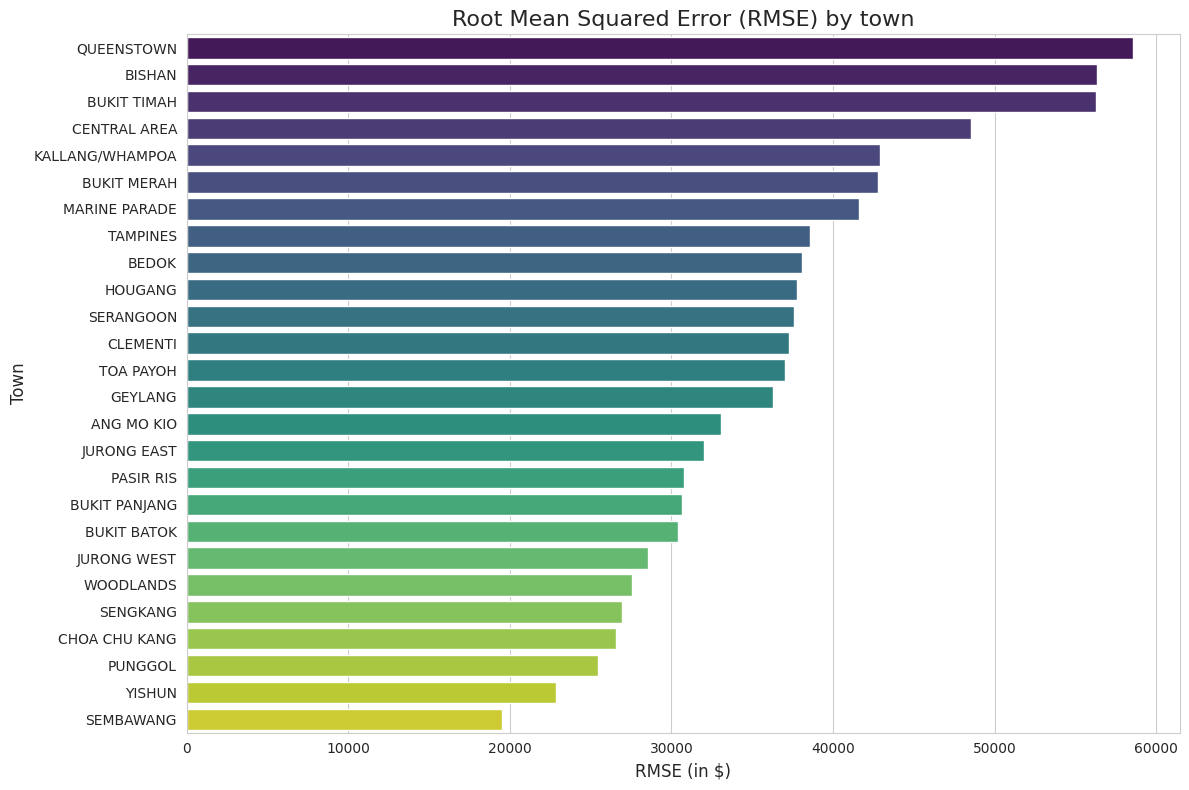

/tmp/ipython-input-2874263757.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')


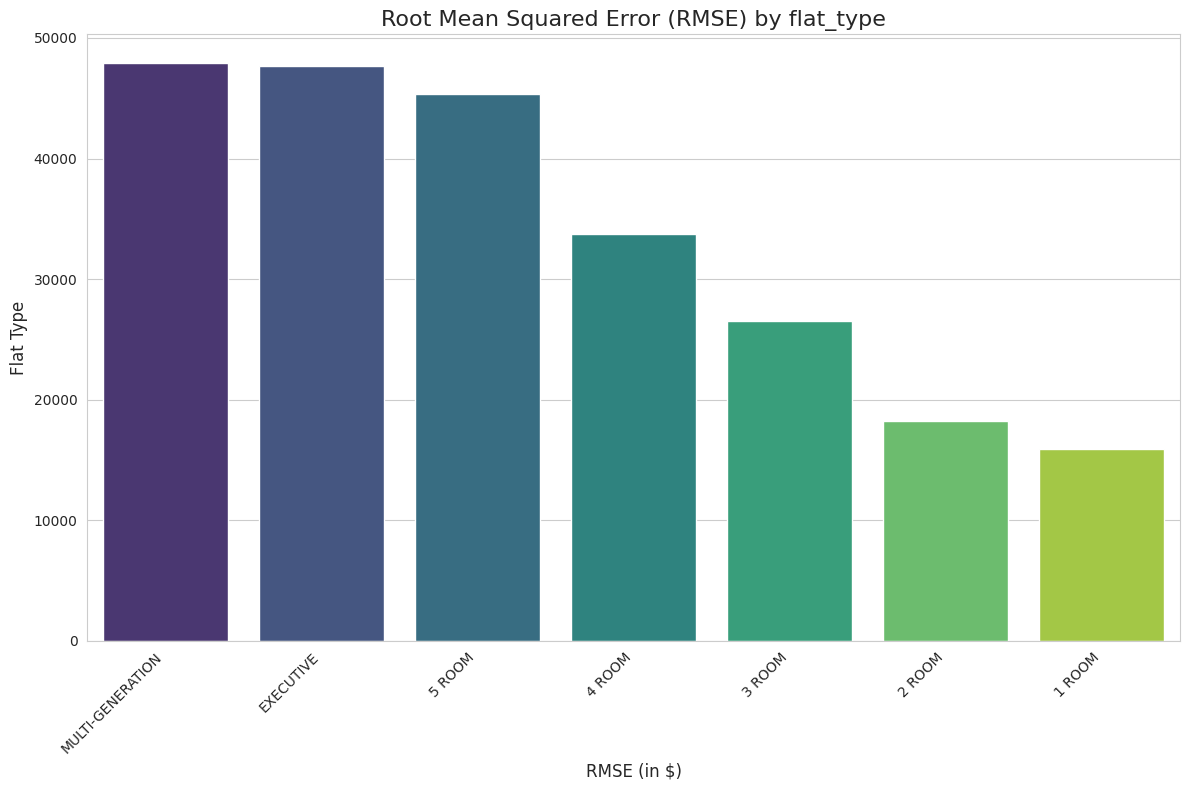

/tmp/ipython-input-2874263757.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


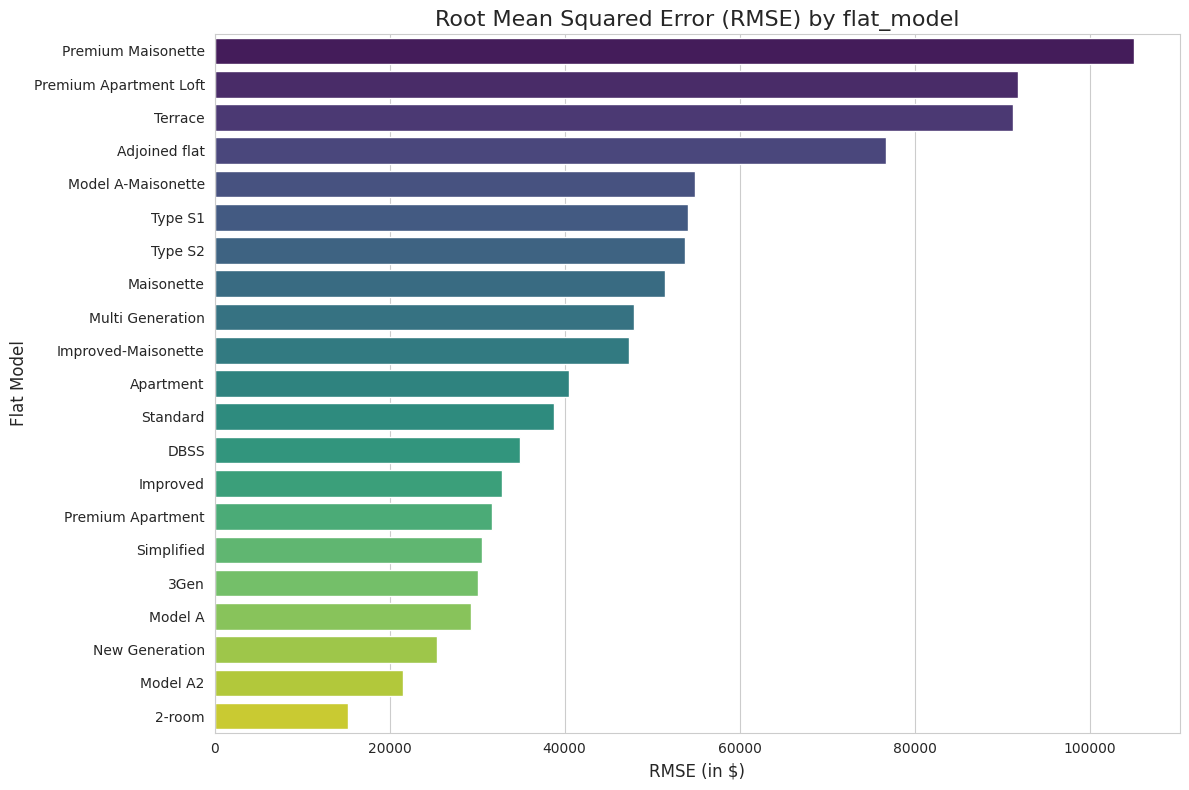

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


xgb_model = XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 200,
    max_depth = 7,
    learning_rate = 0.1,
    subsample = 0.7,
    random_state = 42
)

xgb_model.fit(X_train_preprocessed, y_train_scaled)

# Columns to sample from
sampling_cols = ['town', 'flat_type', 'flat_model']
all_indices = []

# Group by each column and sample 100 from each group
for col in sampling_cols:
    indices = X_test.groupby(col).apply(
        lambda x: x.sample(n=min(len(x), 100), random_state=42)
    ).index.get_level_values(1) # Get the original index
    all_indices.extend(indices)

# Get a set of unique indices to avoid duplicates
unique_indices = sorted(list(set(all_indices)))

# Create the final report datasets using the unique indices
X_classification_report = X_test.loc[unique_indices]
y_classification_report = y_test.loc[unique_indices]


def generate_model_report(model, preprocessor, y_scaler, X_report, y_report):
    # 1) Preprocess and predict (model outputs scaled y if you trained on scaled y)
    X_report_processed = preprocessor.transform(X_report)
    y_pred_scaled = model.predict(X_report_processed)  # shape (n_samples,)

    # 2) Inverse-transform predictions to original units
    #    >>> key change: reshape to 2D for inverse_transform, then ravel back
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # If your y_report is in a pandas Series, this gives a 1D array of true values.
    # (If your stored y_report is STILL SCALED, uncomment the next two lines instead.)
    y_true = y_report.values
    # y_true = y_scaler.inverse_transform(y_report.values.reshape(-1, 1)).ravel()

    # 3) Assemble results
    results_df = X_report.copy()
    results_df['true_price'] = y_true
    results_df['predicted_price'] = y_pred
    results_df['squared_error'] = (results_df['true_price'] - results_df['predicted_price']) ** 2

    # 4) RMSE by category
    report_cols = ['town', 'flat_type', 'flat_model']
    reports = {}

    print("--- Model Performance Report (RMSE) ---\n")
    for col in report_cols:
        rmse_by_class = results_df.groupby(col)['squared_error'].apply(lambda x: np.sqrt(x.mean()))
        report_df = rmse_by_class.reset_index(name='RMSE').sort_values('RMSE', ascending=False)
        reports[col] = report_df

        print(f"----- RMSE by {col} -----")
        print(report_df.to_string(index=False))
        print("\n" + "=" * 40 + "\n")

    # 5) Plots
    sns.set_style("whitegrid")
    for col in report_cols:
        plt.figure(figsize=(12, 8))
        data_to_plot = reports[col].sort_values('RMSE', ascending=False)

        if len(data_to_plot) > 15:
            sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')
        else:
            sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')
            plt.xticks(rotation=45, ha='right')

        plt.title(f'Root Mean Squared Error (RMSE) by {col}', fontsize=16)
        plt.xlabel('RMSE (in $)', fontsize=12)
        plt.ylabel(col.replace('_', ' ').title(), fontsize=12)
        plt.tight_layout()
        plt.show()

# --- Call the function to generate the full report ---
generate_model_report(
    model= xgb_model,
    preprocessor=preprocessor,
    y_scaler=scaler,
    X_report=X_classification_report,
    y_report=y_classification_report
)

In [8]:
import joblib

joblib.dump(xgb_model,"xgb_model.joblib")

['xgb_model.joblib']

In [5]:
X_test_preprocessed.shape

(45316, 71)

In [6]:
X_train_preprocessed.shape

(135946, 71)

# New Section